# Proyek Sistem Rekomendasi Produk E-Commerce

## Deskripsi Proyek
Proyek ini bertujuan membangun sistem rekomendasi produk untuk toko online menggunakan dua pendekatan: **Content-Based Filtering** dan **Collaborative Filtering**. Dataset yang digunakan adalah *E-Commerce Data* dari Kaggle, berisi transaksi pembelian dari toko online di Inggris.

## Tahapan Proyek
1. **Data Understanding**: Memahami struktur dan isi dataset.
2. **Data Preparation**: Membersihkan dan mempersiapkan data untuk modeling.
3. **Modeling**: Membangun sistem rekomendasi.
4. **Evaluation**: Mengevaluasi performa sistem rekomendasi menggunakan metrik **Recall@5**.

## 1. Data Understanding

Dataset *E-Commerce Data* berisi transaksi pembelian dengan kolom utama:
- `InvoiceNo`: Nomor faktur transaksi.
- `StockCode`: Kode unik produk.
- `Description`: Deskripsi produk.
- `Quantity`: Jumlah produk yang dibeli.
- `CustomerID`: ID pelanggan.

Kami akan memuat dataset untuk memahami strukturnya.

In [37]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

# Memuat dataset
ecommerce = pd.read_csv('dataset/data.csv', encoding='latin-1')

# Menampilkan informasi dataset
print('Informasi Dataset:')
print(ecommerce.info())

# Menampilkan 5 baris pertama
print('\nDataset (5 baris pertama):')
print(ecommerce.head())

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None

Dataset (5 baris pertama):
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTL

## 2. Exploratory Data Analysis (EDA)

Kami akan melakukan visualisasi untuk memahami distribusi data:
- Distribusi produk terpopuler berdasarkan jumlah pembelian.
- Distribusi jumlah pembelian per pelanggan.

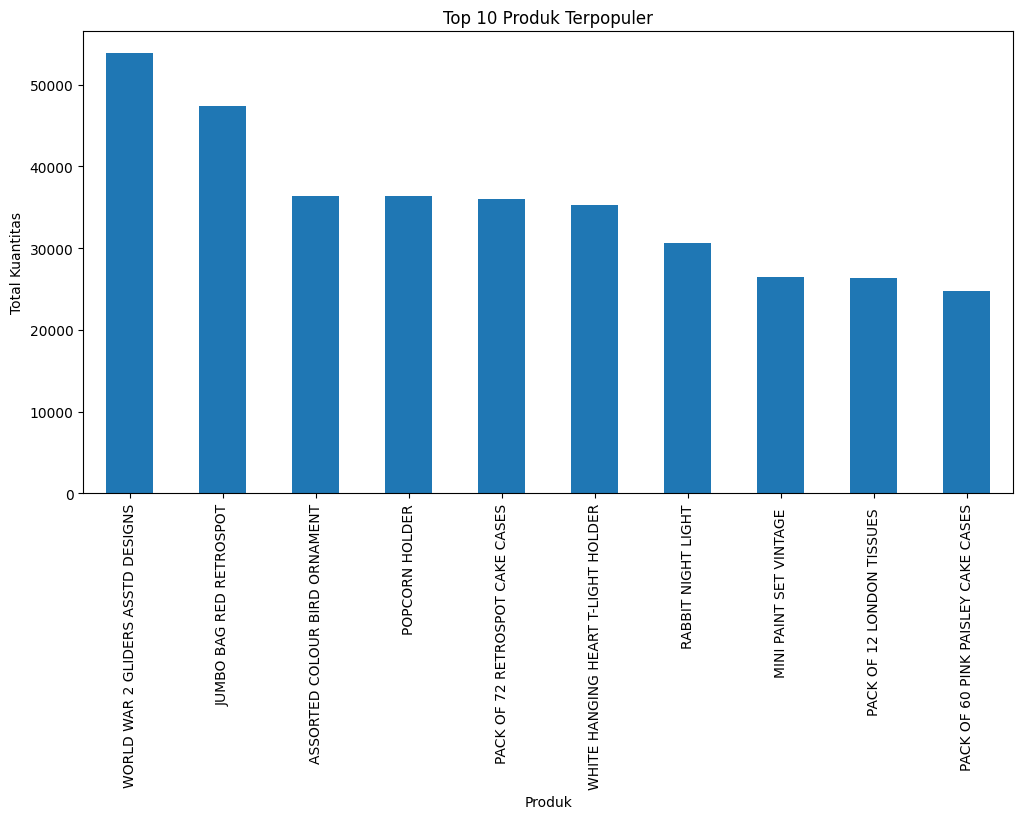

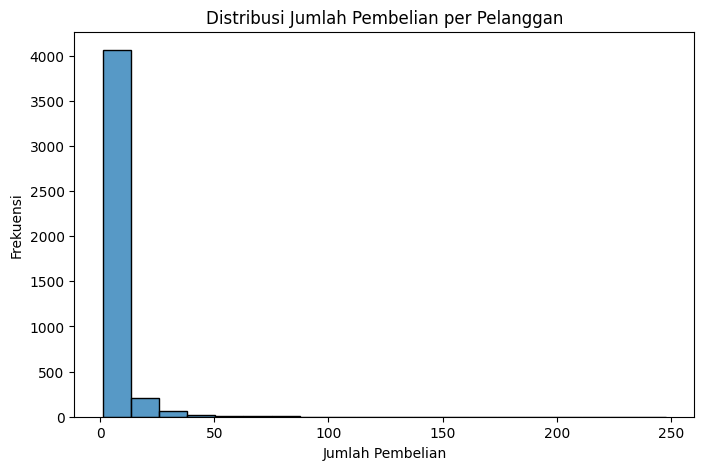

In [38]:
# Visualisasi produk terpopuler
top_products = ecommerce.groupby('Description')['Quantity'].sum().sort_values(ascending=False)[:10]
plt.figure(figsize=(12, 6))
top_products.plot(kind='bar')
plt.title('Top 10 Produk Terpopuler')
plt.xlabel('Produk')
plt.ylabel('Total Kuantitas')
plt.savefig('products.png')
plt.show()

# Visualisasi distribusi pembelian per pelanggan
purchases_per_customer = ecommerce.groupby('CustomerID')['InvoiceNo'].nunique()
plt.figure(figsize=(8, 5))
sns.histplot(purchases_per_customer, bins=20)
plt.title('Distribusi Jumlah Pembelian per Pelanggan')
plt.xlabel('Jumlah Pembelian')
plt.ylabel('Frekuensi')
plt.show()

## 3. Data Preparation

Tahapan ini meliputi:
- **Membersihkan data**: Menghapus baris dengan nilai hilang di kolom `CustomerID` dan `Description`, serta transaksi batal.
- **Memfilter data**: Hanya menyertakan transaksi dengan `Quantity` > 0.
- **Membuat matriks pembelian**: Mengubah data menjadi format user-item untuk collaborative filtering.
- **Menyiapkan deskripsi**: Membersihkan kolom `Description` untuk content-based filtering.

In [39]:
# Membersihkan data
ecommerce = ecommerce.dropna(subset=['CustomerID', 'Description'])
ecommerce = ecommerce[ecommerce['Quantity'] > 0]
ecommerce = ecommerce[~ecommerce['InvoiceNo'].astype(str).str.startswith('C')]  # Menghapus transaksi batal

# Mengubah CustomerID menjadi string
ecommerce['CustomerID'] = ecommerce['CustomerID'].astype(str)

# Membuat matriks user-item (berdasarkan kuantitas)
user_item_matrix = ecommerce.pivot_table(index='CustomerID', columns='StockCode', values='Quantity', aggfunc='sum').fillna(0)

# Membersihkan deskripsi untuk TF-IDF
ecommerce['Description'] = ecommerce['Description'].str.lower().str.replace('[^a-z0-9 ]', '', regex=True)
product_descriptions = ecommerce.groupby('StockCode')['Description'].first().reset_index()

print('Data setelah pembersihan:')
print(ecommerce.info())
print('\nMatriks User-Item (5 baris pertama):')
print(user_item_matrix.head())

Data setelah pembersihan:
<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397924 non-null  object 
 1   StockCode    397924 non-null  object 
 2   Description  397924 non-null  object 
 3   Quantity     397924 non-null  int64  
 4   InvoiceDate  397924 non-null  object 
 5   UnitPrice    397924 non-null  float64
 6   CustomerID   397924 non-null  object 
 7   Country      397924 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 27.3+ MB
None

Matriks User-Item (5 baris pertama):
StockCode   10002  10080  10120  10123C  10124A  10124G  10125  10133  10135  \
CustomerID                                                                     
12346.0       0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0    0.0   
12347.0       0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0    0.0   
12348.0      

## 4. Modeling

Kami akan membangun dua sistem rekomendasi:
- **Content-Based Filtering**: Menggunakan TF-IDF dan cosine similarity berdasarkan deskripsi produk.
- **Collaborative Filtering**: Menggunakan SVD untuk matrix factorization berdasarkan pola pembelian.

### 4.1 Content-Based Filtering

Menggunakan deskripsi produk untuk merekomendasikan produk serupa.

In [40]:
# TF-IDF Vectorizer untuk deskripsi
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(product_descriptions['Description'])

# Menghitung cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Fungsi rekomendasi
def get_content_based_recommendations(stock_code, cosine_sim=cosine_sim, df=product_descriptions, top_n=5):
    idx = df[df['StockCode'] == stock_code].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    product_indices = [i[0] for i in sim_scores]
    return df['Description'].iloc[product_indices]

# Contoh rekomendasi
example_product = product_descriptions['StockCode'].iloc[0]
print(f'Rekomendasi untuk produk {example_product}:')
print(get_content_based_recommendations(example_product))

Rekomendasi untuk produk 10002:
1       groovy cactus inflatable
2                   doggy rubber
3          hearts wrapping tape 
4    spots on red bookcover tape
5       army camo bookcover tape
Name: Description, dtype: object


### 4.2 Collaborative Filtering

Menggunakan SVD untuk merekomendasikan produk berdasarkan pola pembelian.

In [41]:
# SVD
svd = TruncatedSVD(n_components=20, random_state=42)
matrix_svd = svd.fit_transform(user_item_matrix)

# Menghitung similarity antar pelanggan
user_sim = cosine_similarity(matrix_svd)

# Fungsi rekomendasi
def get_collaborative_recommendations(customer_id, user_sim=user_sim, user_item_matrix=user_item_matrix, df=product_descriptions, top_n=5):
    user_idx = user_item_matrix.index.get_loc(customer_id)
    sim_scores = list(enumerate(user_sim[user_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_users = [i[0] for i in sim_scores[1:11]]  # Top 10 pelanggan serupa
    
    # Mendapatkan produk yang dibeli pelanggan serupa
    sim_user_purchases = user_item_matrix.iloc[sim_users]
    product_scores = sim_user_purchases.mean(axis=0)
    product_scores = product_scores[product_scores > 0]
    top_product_ids = product_scores.sort_values(ascending=False).head(top_n).index
    
    return df[df['StockCode'].isin(top_product_ids)]['Description']

# Contoh rekomendasi
example_customer = user_item_matrix.index[0]
print(f'Rekomendasi untuk pelanggan {example_customer}:')
print(get_collaborative_recommendations(example_customer))

Rekomendasi untuk pelanggan 12346.0:
547                       red pudding spoon
548                      blue pudding spoon
1432    wooden heart christmas scandinavian
1997         medium ceramic top storage jar
1998         small ceramic top storage jar 
Name: Description, dtype: object


## 5. Evaluation

Kami akan menggunakan metrik **Recall@5** untuk mengevaluasi rekomendasi.

- **Content-Based**: Mengevaluasi apakah produk yang direkomendasikan memiliki deskripsi serupa dengan produk input.
- **Collaborative**: Mengevaluasi apakah produk yang direkomendasikan sesuai dengan pembelian pelanggan.

In [42]:
# Fungsi evaluasi Recall@5 untuk content-based
def evaluate_content_based(stock_code, recommendations, df=product_descriptions, ecommerce_df=ecommerce):
    target_desc = set(df[df['StockCode'] == stock_code]['Description'].str.split().iloc[0])
    # Menganggap produk dengan kata serupa dalam deskripsi sebagai relevan
    relevant_items = set(df[df['Description'].apply(lambda x: bool(set(x.split()).intersection(target_desc)))]['StockCode'])
    rec_ids = set(df[df['Description'].isin(recommendations)]['StockCode'])
    hits = len(relevant_items.intersection(rec_ids))
    return hits / len(relevant_items) if relevant_items else 0

# Fungsi evaluasi Recall@5 untuk collaborative
def evaluate_collaborative(customer_id, recommendations, ecommerce_df=ecommerce, product_df=product_descriptions):
    relevant_items = set(ecommerce_df[ecommerce_df['CustomerID'] == customer_id]['StockCode'])
    rec_ids = set(product_df[product_df['Description'].isin(recommendations)]['StockCode'])
    hits = len(relevant_items.intersection(rec_ids))
    return hits / len(relevant_items) if relevant_items else 0

# Contoh evaluasi
cb_recs = get_content_based_recommendations(example_product)
cf_recs = get_collaborative_recommendations(example_customer)

print(f'Recall@5 Content-Based untuk produk {example_product}:', evaluate_content_based(example_product, cb_recs))
print(f'Recall@5 Collaborative untuk pelanggan {example_customer}:', evaluate_collaborative(example_customer, cf_recs))

Recall@5 Content-Based untuk produk 10002: 0.5
Recall@5 Collaborative untuk pelanggan 12346.0: 1.0
